In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

from torch.utils.tensorboard import SummaryWriter
import torch
import torchvision.utils as vutils
from tqdm import tqdm
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams.update({'font.size': 18})

In [2]:
features = np.load(f'DataSet/Features_Diff_1.npz')['Features_Diff_1']
print(features.shape)

(151839, 71, 8)


In [3]:
data = features[0:90000]

In [4]:
input_window = 47
output_window = 24

# 用来存储输入和输出的列表
inputs = []
outputs = []

# 为了确保没有超出数组的界限，我们创建一个循环，截止到可以完整提取一个输入加一个输出的位置
for i in range(data.shape[1] - input_window - output_window + 1):
    # 对每一个样本处理
    for sample in data:
        inputs.append(sample[i:i + input_window])
        outputs.append(sample[i + input_window: i + input_window + output_window])

inputs = np.array(inputs)
outputs = np.array(outputs)

# 转换为torch.Tensor
inputs_tensor = torch.from_numpy(inputs).float()
outputs_tensor = torch.from_numpy(outputs).float()

# 划分训练集和测试集
num_samples = inputs_tensor.shape[0]
train_size = int(num_samples * 0.8)

train_inputs = inputs_tensor[:train_size]
train_outputs = outputs_tensor[:train_size]
test_inputs = inputs_tensor[train_size:]
test_outputs = outputs_tensor[train_size:]

# 创建数据集和数据加载器
train_dataset = TensorDataset(train_inputs, train_outputs)
train_loader = DataLoader(train_dataset, batch_size=180, shuffle=True, num_workers=16, pin_memory=True)

test_dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(test_dataset, batch_size=180, shuffle=False, num_workers=16, pin_memory=True)

# 验证输出形状
print("Train inputs shape:", train_inputs.shape)
print("Train outputs shape:", train_outputs.shape)
print("Test inputs shape:", test_inputs.shape)
print("Test outputs shape:", test_outputs.shape)

Train inputs shape: torch.Size([72000, 47, 8])
Train outputs shape: torch.Size([72000, 24, 8])
Test inputs shape: torch.Size([18000, 47, 8])
Test outputs shape: torch.Size([18000, 24, 8])


In [5]:
# class NBeatsBlock(nn.Module):
#     def __init__(self, input_size, hidden_units):
#         super().__init__()
#         self.fc1 = nn.Linear(input_size, hidden_units)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_units, hidden_units)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(hidden_units, input_size)  # 输出与输入相同长度

#     def forward(self, x):
#         x = self.relu1(self.fc1(x))
#         x = self.relu2(self.fc2(x))
#         return self.fc3(x)

# class NBeatsModel(nn.Module):
#     def __init__(self, num_blocks, input_size, output_size, hidden_units):
#         super().__init__()
#         self.output_size = output_size
#         self.blocks = nn.ModuleList([NBeatsBlock(input_size, hidden_units) for _ in range(num_blocks)])
#         self.output_layer = nn.Linear(input_size * num_blocks, output_size)  # 重新调整最终输出长度

#     def forward(self, x):
#         forecasts = []
#         for block in self.blocks:
#             out = block(x)
#             forecasts.append(out)
#             x = x - out  # 计算残差
            
#         forecast = torch.cat(forecasts, dim=-1)
#         return self.output_layer(forecast)  # 只取最终输出的一部分

In [6]:
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, hidden_units):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_units, input_size)  # Output is the same length as input

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

class NBeatsModel(nn.Module):
    def __init__(self, num_blocks, input_size, output_size, hidden_units):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.blocks = nn.ModuleList([NBeatsBlock(input_size, hidden_units) for _ in range(num_blocks)])
        self.output_layer = nn.Linear(input_size * num_blocks, output_size)  # Adjust final output length

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input to (batch_size, input_size)
        forecasts = []
        for block in self.blocks:
            out = block(x)
            forecasts.append(out)
            x = x - out  # Residual connection
            
        forecast = torch.cat(forecasts, dim=-1)
        forecast = self.output_layer(forecast)  # Shape the output to desired output size
        forecast = forecast.view(forecast.size(0), 24, 8)  # Reshape to (batch_size, 24, 8)
        return forecast

In [7]:
Num_Feature = 8

# 设定模型参数
input_size = input_window * Num_Feature  # 输入窗口长度*特征数量
theta_size = output_window * Num_Feature  # 输出窗口长度*特征数量
hidden_units = 512
num_blocks = 4

# 创建模型
model = NBeatsModel(num_blocks, input_size, theta_size, hidden_units)

In [14]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(1)

model.apply(init_weights)

NBeatsModel(
  (blocks): ModuleList(
    (0-3): 4 x NBeatsBlock(
      (fc1): Linear(in_features=376, out_features=512, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=512, out_features=512, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=512, out_features=376, bias=True)
    )
  )
  (output_layer): Linear(in_features=1504, out_features=192, bias=True)
)

In [15]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    writer = SummaryWriter(log_dir='runs/N-BEATS')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc='Training', leave=True)
        for inputs, targets in progress_bar:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({'loss': loss.item()})
        train_loss /= len(train_loader.dataset)
        test_loss = evaluate_model(model, test_loader, criterion)
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/test', test_loss, epoch)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    writer.close()

In [16]:
def evaluate_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    return test_loss

In [17]:
learning_rate = 0.002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Model initialization
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25)

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Training: 100%|██████████| 400/400 [00:23<00:00, 17.13it/s, loss=0.0597] 


Epoch 1/25, Train Loss: 3.2948, Test Loss: 0.0581


Training: 100%|██████████| 400/400 [00:10<00:00, 39.03it/s, loss=0.0511] 


Epoch 2/25, Train Loss: 0.0508, Test Loss: 0.0427


Training: 100%|██████████| 400/400 [00:09<00:00, 40.45it/s, loss=0.0232] 


Epoch 3/25, Train Loss: 0.0399, Test Loss: 0.0346


Training: 100%|██████████| 400/400 [00:11<00:00, 35.67it/s, loss=0.0322] 


Epoch 4/25, Train Loss: 0.0350, Test Loss: 0.0305


Training: 100%|██████████| 400/400 [00:11<00:00, 36.13it/s, loss=0.0296]


Epoch 5/25, Train Loss: 0.0321, Test Loss: 0.0292


Training: 100%|██████████| 400/400 [00:10<00:00, 38.82it/s, loss=0.0274] 


Epoch 6/25, Train Loss: 0.0297, Test Loss: 0.0268


Training: 100%|██████████| 400/400 [00:15<00:00, 26.35it/s, loss=0.0301] 


Epoch 7/25, Train Loss: 0.0285, Test Loss: 0.0261


Training: 100%|██████████| 400/400 [00:11<00:00, 35.62it/s, loss=0.0254] 


Epoch 8/25, Train Loss: 0.0278, Test Loss: 0.0242


Training: 100%|██████████| 400/400 [00:13<00:00, 30.55it/s, loss=0.0223]


Epoch 9/25, Train Loss: 0.0261, Test Loss: 0.0244


Training: 100%|██████████| 400/400 [00:12<00:00, 32.42it/s, loss=0.0263]


Epoch 10/25, Train Loss: 0.0255, Test Loss: 0.0264


Training: 100%|██████████| 400/400 [00:13<00:00, 30.60it/s, loss=0.0196]


Epoch 11/25, Train Loss: 0.0251, Test Loss: 0.0244


Training: 100%|██████████| 400/400 [00:14<00:00, 27.68it/s, loss=0.0126] 


Epoch 12/25, Train Loss: 0.0250, Test Loss: 0.0234


Training: 100%|██████████| 400/400 [00:10<00:00, 37.64it/s, loss=0.0204] 


Epoch 13/25, Train Loss: 0.0243, Test Loss: 0.0234


Training: 100%|██████████| 400/400 [00:13<00:00, 29.67it/s, loss=0.0335] 


Epoch 14/25, Train Loss: 0.0239, Test Loss: 0.0233


Training: 100%|██████████| 400/400 [00:12<00:00, 32.99it/s, loss=0.0325]


Epoch 15/25, Train Loss: 0.0243, Test Loss: 0.0229


Training: 100%|██████████| 400/400 [00:12<00:00, 33.07it/s, loss=0.0303]


Epoch 16/25, Train Loss: 0.0237, Test Loss: 0.0242


Training: 100%|██████████| 400/400 [00:18<00:00, 22.07it/s, loss=0.0193]


Epoch 17/25, Train Loss: 0.0240, Test Loss: 0.0218


Training: 100%|██████████| 400/400 [00:17<00:00, 23.43it/s, loss=0.028] 


Epoch 18/25, Train Loss: 0.0230, Test Loss: 0.0222


Training: 100%|██████████| 400/400 [00:13<00:00, 29.00it/s, loss=0.028] 


Epoch 19/25, Train Loss: 0.0236, Test Loss: 0.0228


Training: 100%|██████████| 400/400 [00:15<00:00, 25.52it/s, loss=0.0337] 


Epoch 20/25, Train Loss: 0.0234, Test Loss: 0.0215


Training: 100%|██████████| 400/400 [00:14<00:00, 27.87it/s, loss=0.0139]


Epoch 21/25, Train Loss: 0.0233, Test Loss: 0.0220


Training: 100%|██████████| 400/400 [00:13<00:00, 29.68it/s, loss=0.022] 


Epoch 22/25, Train Loss: 0.0231, Test Loss: 0.0237


Training: 100%|██████████| 400/400 [00:15<00:00, 26.45it/s, loss=0.025]  


Epoch 23/25, Train Loss: 0.0230, Test Loss: 0.0246


Training: 100%|██████████| 400/400 [00:12<00:00, 31.68it/s, loss=0.0352] 


Epoch 24/25, Train Loss: 0.0233, Test Loss: 0.0239


Training: 100%|██████████| 400/400 [00:17<00:00, 22.72it/s, loss=0.0248] 


Epoch 25/25, Train Loss: 0.0228, Test Loss: 0.0215


In [ ]:
torch.save(model.state_dict(), 'Model_Path/N_BEATS.pth')

In [8]:
model = NBeatsModel(num_blocks, input_size, theta_size, hidden_units)
model.load_state_dict(torch.load('Model_Path/N_BEATS.pth'))

<All keys matched successfully>

In [41]:
# 查看tensorboard
# tensorboard --logdir=runs

torch.Size([1, 24, 8])


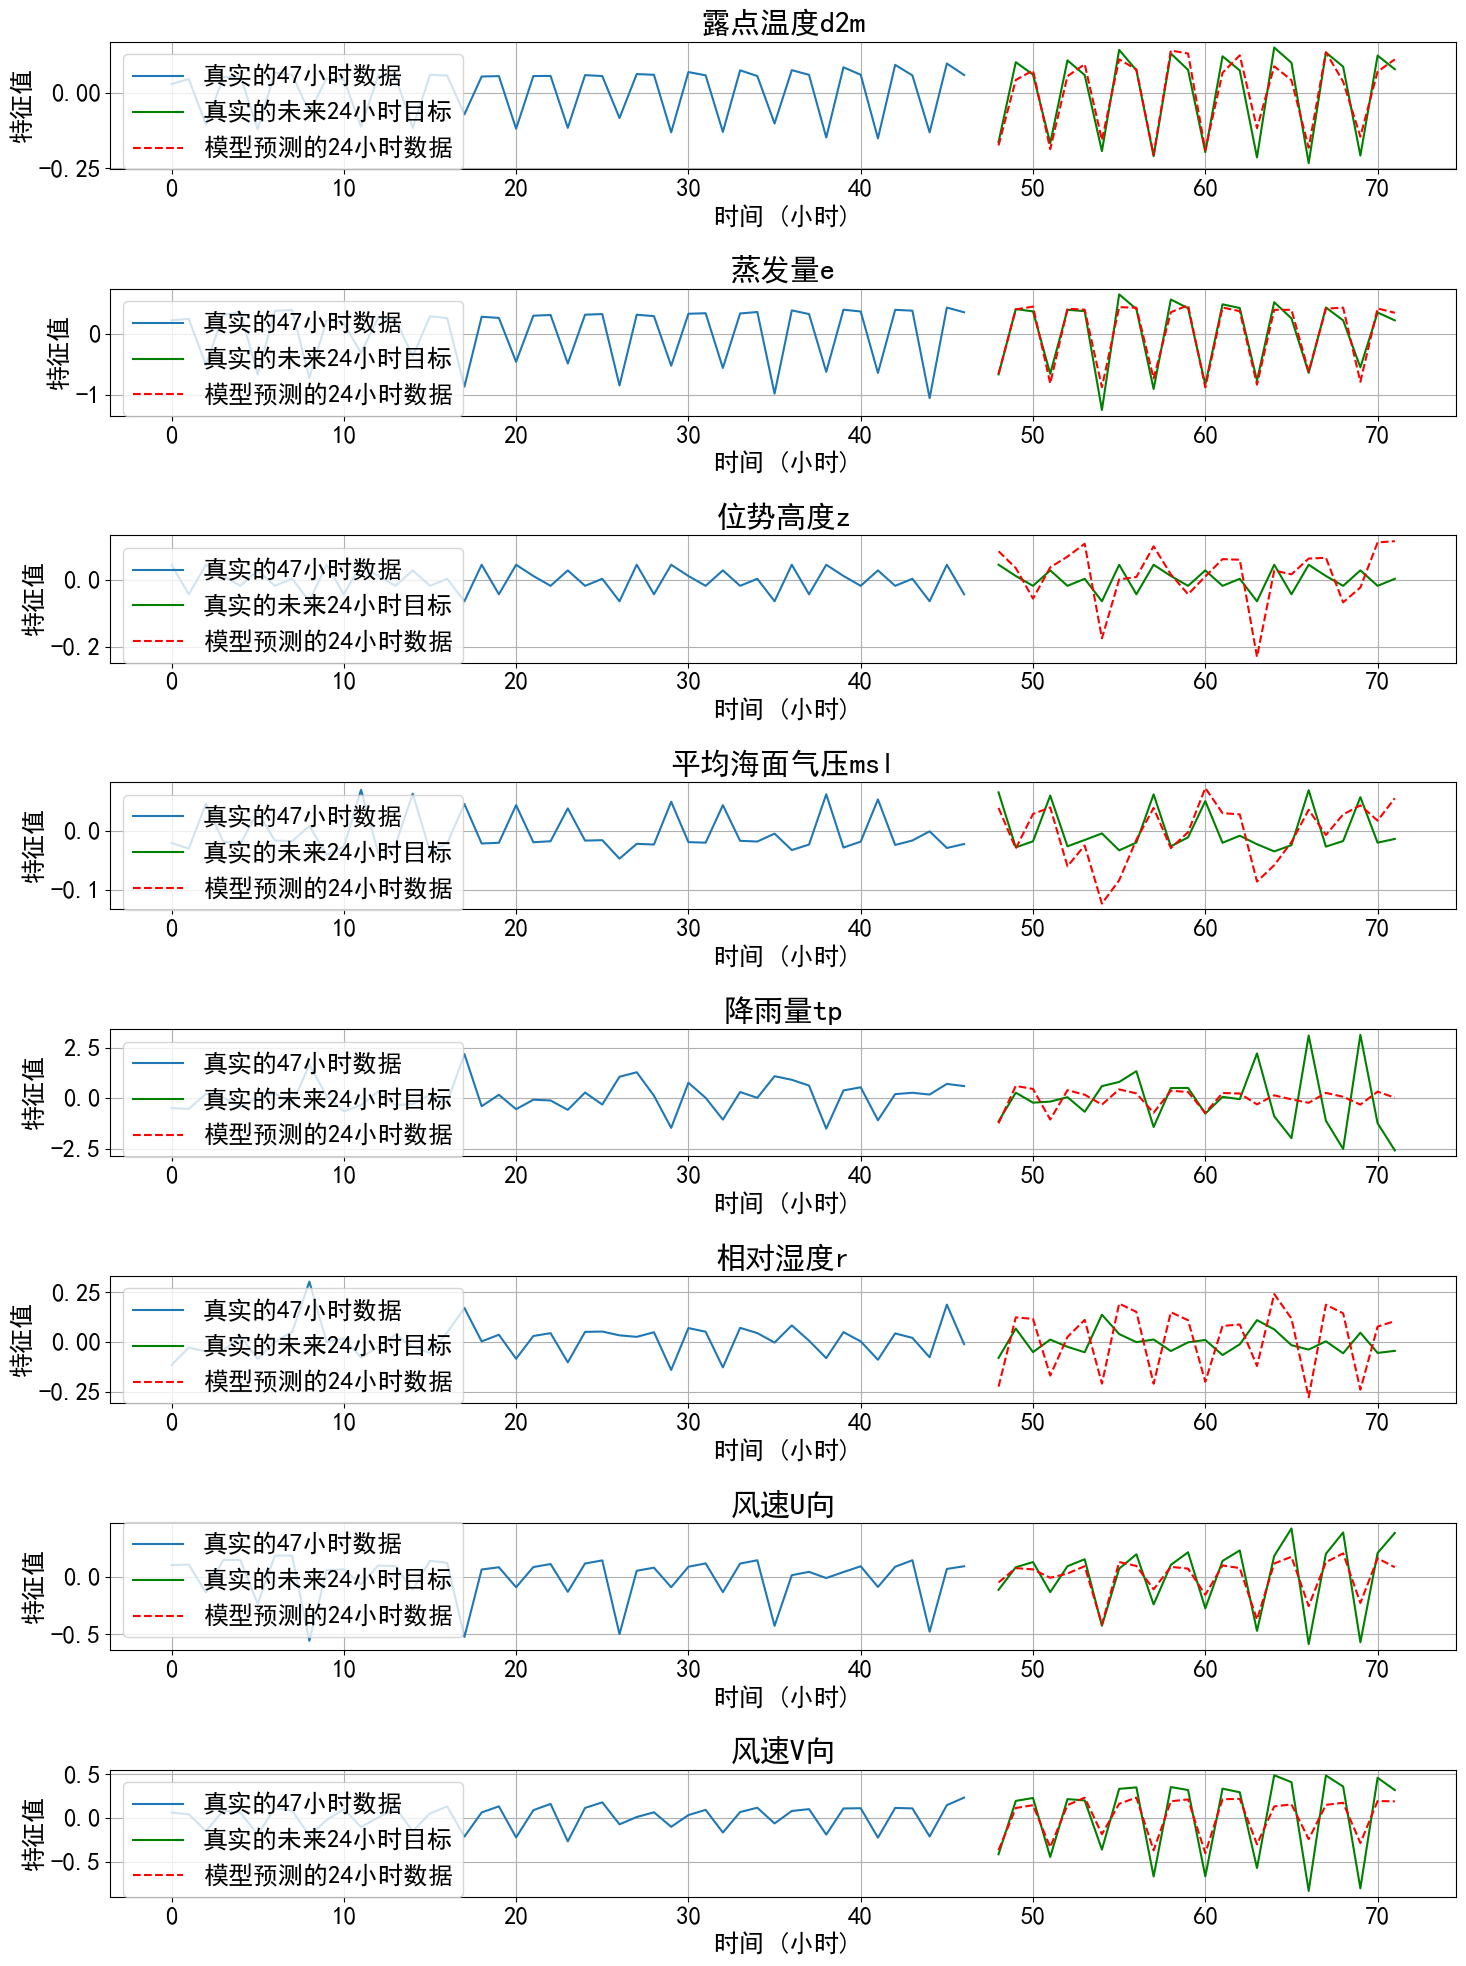

In [9]:
Num_Feature = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
variable_names = ['露点温度d2m', '蒸发量e','位势高度z','平均海面气压msl', '降雨量tp','相对湿度r','风速U向','风速V向']
def evaluate_and_plot_features(model, test_loader):
    for batch in test_loader:
        inputs, targets = batch
        model = model.to(device)
        inputs = inputs.to(device)
        output = model(inputs)
        # 选择第一个样本
        single_input = inputs[0:1].to(device)
        single_target = targets[0:1].to(device)
        output = output[0:1].to(device)
        break  # 只处理第一个batch
    # 将数据移回CPU以便打印或进一步处理
    print(output.shape)

    
    single_input = single_input.cpu().view(-1, Num_Feature)
    single_target = single_target.cpu().view(-1, Num_Feature)
    output = output.cpu().view(-1, Num_Feature)

    # 绘制每个特征的图表
    num_features = Num_Feature
    plt.figure(figsize=(15, 20))
    for i in range(num_features):
        plt.subplot(num_features, 1, i+1)
        plt.plot(single_input[:, i], label='真实的47小时数据')
        plt.plot(range(48, 72), single_target[:, i], 'g', label='真实的未来24小时目标')
        plt.plot(range(48, 72), output[:, i].detach().numpy(), 'r--', label='模型预测的24小时数据')
        plt.title(variable_names[i])
        plt.xlabel('时间 (小时)')
        plt.ylabel(f'特征值')
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

# 调用函数
evaluate_and_plot_features(model, test_loader)